In [1]:
import os
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import wandb
from pathlib import Path
import orbax.checkpoint
from flax.training import train_state, orbax_utils
from sklearn.metrics import roc_auc_score, roc_curve, auc
import models
import data_utils
from absl import logging, app, flags
from tqdm import tqdm

In [2]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("mingfong/fullsim")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [3]:
df = pd.read_csv("wandb_fullsim_runs.csv")

In [4]:
for row in df.iterrows():
  current_id = row[1]["ID"]
  print(current_id)
  path = Path("/pscratch/sd/m/mingfong/transfer-learning/wandb/")
  current_wandb_run_dir = list(path.glob(f"**/*{current_id}"))[0]
  artifact = api.artifact(f"mingfong/fullsim/{current_id}-checkpoint:latest")   # TODO figure out which checkpoint had best performance to download
  artifact.download(root=f"/pscratch/sd/m/mingfong/transfer-learning/checkpoints/{current_id}/")

532gak2v


wandb:   1 of 1 files downloaded.  


veyvse59


wandb:   1 of 1 files downloaded.  


b483kdg6


wandb:   1 of 1 files downloaded.  


f7otgiky


wandb:   1 of 1 files downloaded.  


yhexvltv


wandb:   1 of 1 files downloaded.  


xwb9lvdo


wandb:   1 of 1 files downloaded.  


6rgky02g


wandb:   1 of 1 files downloaded.  


wtq686zk


wandb:   1 of 1 files downloaded.  


4rqwunj6


wandb:   1 of 1 files downloaded.  


gb736s9n


wandb:   1 of 1 files downloaded.  


0ib37wsb


wandb:   1 of 1 files downloaded.  


btda5j3c


wandb:   1 of 1 files downloaded.  


a2ypm3lr


wandb:   1 of 1 files downloaded.  


co3u843s


wandb:   1 of 1 files downloaded.  


8scyomvw


wandb:   1 of 1 files downloaded.  


mwbrtifb


wandb:   1 of 1 files downloaded.  


afpv10i8


wandb:   1 of 1 files downloaded.  


8kv2yvi0


wandb:   1 of 1 files downloaded.  


79ka8j6l


wandb:   1 of 1 files downloaded.  


oobw6u19


wandb:   1 of 1 files downloaded.  


25ao9xre


wandb:   1 of 1 files downloaded.  


wl0uyh35


wandb:   1 of 1 files downloaded.  


ao7s8qoe


wandb:   1 of 1 files downloaded.  


ulw1w4nn


wandb:   1 of 1 files downloaded.  


ujrwfssb


wandb:   1 of 1 files downloaded.  


## Inference Pipeline on TEST dataset

In [5]:
SEED = 1

rng = np.random.RandomState(SEED)
rng_key = jax.random.PRNGKey(rng.randint(2**32))

def init_train_state(rng_key, model, optimizer, batch):
  """Initialize training state."""
  params = model.init(rng_key, batch)
  return train_state.TrainState.create(
      apply_fn=model.apply,
      params=params,
      tx=optimizer)

@jax.jit
def eval_step(
  state: train_state.TrainState,
  batch: jnp.ndarray,
  ):
  """Perform a single evaluation step."""
  x, y = batch
  logits = state.apply_fn(state.params, x).squeeze()
  loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=y))
  return loss, logits

In [6]:
# testing data loading
BATCH_SIZE = 1024
MAX_ROWS = None # None for all

test_dir_preprocess = "/pscratch/sd/m/mingfong/transfer-learning/fullsim_test_processed/"
test_preprocess_file_names = os.listdir(test_dir_preprocess)
test_preprocess_filepaths = [test_dir_preprocess + name for name in test_preprocess_file_names]

DatasetClassToUse = data_utils.H5DatasetLoadAll

test_dataset = DatasetClassToUse(test_preprocess_filepaths[-1:], max_rows=MAX_ROWS, reverse_data=True)
test_dataloader = data_utils.JaxDataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
logging.info("Num val samples: %s", len(test_dataset))

dummy_input = next(iter(test_dataloader))[0]
logging.info("Input shape: %s", dummy_input.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:26<?, ?it/s]


In [7]:
DNN_LAYERS = [400, 400, 400, 400, 400, 1]
LEARNING_RATE = 0.0001

model = models.MLP(features=DNN_LAYERS)
opt = optax.adam(LEARNING_RATE)
state = init_train_state(rng_key, model, opt, dummy_input)

# load checkpoint for params
ckpt = {
  "step": 0,
  "state": state,
}
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)

CHECKPOINT_DIR = "/pscratch/sd/m/mingfong/transfer-learning/checkpoints/532gak2v/"
raw_restored = orbax_checkpointer.restore(CHECKPOINT_DIR, item=ckpt)
state = raw_restored["state"]
start_step = raw_restored["step"] + 1

In [8]:
test_datagen = iter(test_dataloader)
test_batch_matrics = {
  "loss": [],
  "accuracy": [],
  "auc": [],
}
logits_list = []
y_true_list = []

for batch_step in tqdm(range(len(test_dataloader))):
  batch = next(test_datagen)
  loss, logits = eval_step(state, batch)
  test_batch_matrics["loss"].append(loss)
  test_batch_matrics["accuracy"].append(jnp.mean((logits > 0) == batch[1]))
  test_batch_matrics["auc"].append(roc_auc_score(batch[1], logits))
  logits_list.append(logits)
  y_true_list.append(batch[1])

100%|██████████| 2426/2426 [00:32<00:00, 73.98it/s]


In [12]:
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(logits_list)
print(y_true.shape, y_pred.shape)

(2484117,) (2484117,)


In [10]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

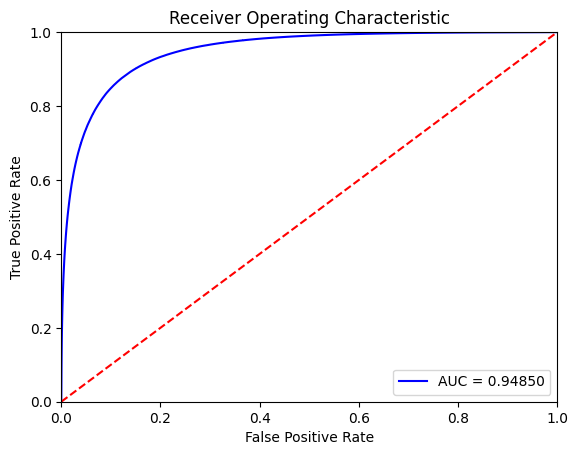

In [13]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()